# Sequential Low Rank Regression

## Key Contributions:

1. **[Sub-routine agnostic]** We characterize how the errors from approximately solving the sub-routine (`PCA`) propagate into the overall error of the deflation procedure. Informally, the error between the approximately principal component and the actual one needs to be exponentially small to control the accuracy for the top-*K* eigenvectors for an increasing *K*, where the base of the exponential growth depends on the eigengap of the target matrix.
2. **[Sub-routing specific]** We consider the case where `PCA` is set to `Power Iteration` method. By leveraging the directional information of the numerical error vector produced by each power iteration, we improve the error bound in the previous step to exponential growth with constant base

In [17]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds, eigs

from dataclasses import dataclass


seed = 42
np.random.seed(seed)

## Step 0: Initialization

In [118]:
# Dimension of the matrix W (W = AB^T)
d = 100
m = 50
n = 500  # Number of samples
r = 10  # Rank of the matrix W

# Generating n input data points with d features with a normal distribution
X = np.random.randn(n, d)

# Normalizing the rows of X
X = X / la.norm(X, axis=1, keepdims=True)

# Generating Sigma, the diagonal matrix
S_star = np.geomspace(100, 1, num=r)
S_star_sqrt = np.diag(np.sqrt(S_star))

# Generating M
M = np.random.randn(d, m)
[U_star, temp, V_star] = la.svd(M)  # Performing SVD on M

# Generating A^* and B^*
A_star_hat = U_star[:, :r]  # Top-r left singular vectors
B_star_hat = V_star[:r, :].T  # Top-r right singular vectors

# Generating A* and B*
A_star = A_star_hat @ S_star_sqrt
B_star = B_star_hat @ S_star_sqrt
W_star = A_star @ B_star.T
# W_star = W_star / la.norm(W_star, 'fro')

# Noise
std = 5e-1
Z = np.random.randn(n, m)
Z = std * (1 / la.norm(Z, 'fro')) * Z

# Generating Y
Y = X @ W_star + Z

# Calculating the Lipschitz constant of H (Spectral Norm)
H = X.T @ X
[u, s, v] = svds(H, k=1)
L = s[0] # Spectral norm of H

# Setting learning rate eta
eta = 1/L
print(f"Learning rate `eta` = {eta}")


Learning rate `eta` = 0.10050341345327195


In [120]:
U_star.shape, temp.shape, V_star.shape

((100, 100), (50,), (50, 50))

In [121]:
@dataclass
class GDArgs:
    d: int = d # Dimensionality of the input data
    r: int = r # Rank of the matrix W
    m: int = m # Number of columns in the matrix M
    n: int = n # Number of samples
    eta: float = eta # Learning rate
    eta_A: float = eta
    eta_B: float = eta
    iters: int = 1000 # Maximum number of iterations
    epsilon: float = 1e-8 # Tolerance for Relative error (As compared to W*)
    lambda_orth: float = 0.7 # Regularization parameter for orthogonality

## Step 1.1: Implementing Simple Gradient Descent

In [20]:
def GD(X, Y, W_star, args: GDArgs):
    W_old = np.random.randn(args.d, args.m)
    i = 1

    rel_errors = []
    while i <= args.iters:
        grad = X.T @ (X @ W_old - Y)

        # print(la.matrix_rank(grad))

        W_new = W_old - args.eta * grad

        # Calculate the relative error
        rel_error = la.norm(W_new - W_star, "fro") / la.norm(W_star, "fro")
        rel_errors.append(rel_error)

        # check if the relative error between W and W* is smaller than epsilon
        if rel_error <= args.epsilon:
            print("Tolerance Error reached. Stopping the algorithm.")
            break

        W_old = W_new
        i += 1
    return W_new, rel_errors


# W_star and r are not used in the function yet

Rank of W: 100


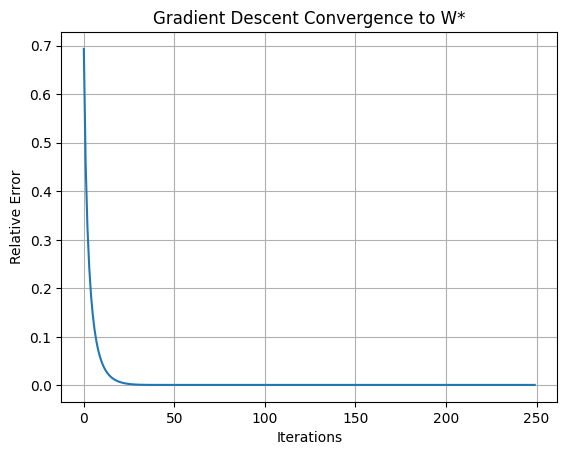

In [21]:
# Sanity check for the GD function

args = GDArgs(iters=250)

W, rel_errors = GD(X, Y, W_star, args)
print(f"Rank of W: {la.matrix_rank(W)}")

# Plotting the relative error
plt.plot(rel_errors)
plt.xlabel('Iterations')
plt.ylabel('Relative Error')
plt.title('Gradient Descent Convergence to W*')
plt.grid()
plt.show()


## Step 1.2: Implementing Iterative Hard-Thresholding [Projected Gradient Descent]

In [22]:
def IHT(X, Y, W_star, args: GDArgs):

    W_old = np.random.randn(args.d, args.m)
    rel_errors = []
    i = 1
    while i <= args.iters:
        grad = X.T @ (X @ W_old - Y)

        # print(la.matrix_rank(grad))

        W_mid = W_old - args.eta * grad

        # Projecting W_new to become r-rank
        U, S, V = la.svd(W_mid)
        W_new = U[:, : args.r] @ np.diag(S[: args.r]) @ V[: args.r, :]

        # Compute the relative error
        rel_error = la.norm(W_new - W_star, ord="fro") / la.norm(W_star, ord="fro")
        rel_errors.append(rel_error)

        # check if the error between W and W* is smaller than the epsilon
        if rel_error <= args.epsilon:
            print("Tolerance Error reached. Stopping the algorithm.")
            break

        W_old = W_new
        i += 1
    return W_new, rel_errors


# W_star is not used in the function yet

Rank of W_IHT: 10


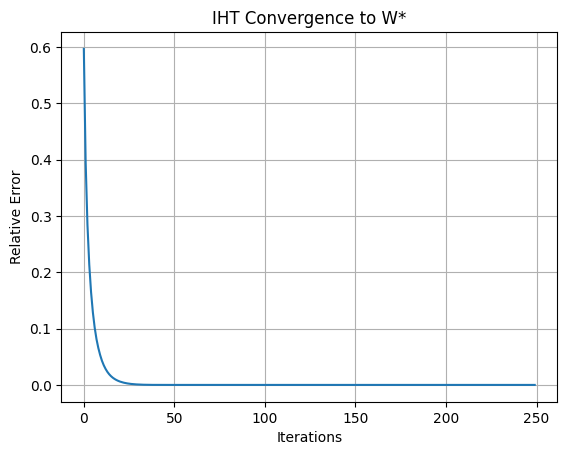

In [23]:
# Sanity check for the IHT function
W_IHT, rel_errors = IHT(X, Y, W_star, args)

print(f"Rank of W_IHT: {la.matrix_rank(W_IHT)}")

# Plotting the relative error
plt.plot(rel_errors)
plt.xlabel('Iterations')
plt.ylabel('Relative Error')
plt.title('IHT Convergence to W*')
plt.grid()
plt.show()

In [24]:
print(f"Distance between W and W_star: {la.norm(W - W_star, ord='fro')}")
print(f"Distance between W_IHT and W_star: {la.norm(W_IHT - W_star, ord='fro')}\n")

print(f"Relative Error of W: {la.norm(W - W_star, ord='fro') / la.norm(W_star, ord='fro')}")
print(f"Relative Error of W_IHT: {la.norm(W_IHT - W_star, ord='fro') / la.norm(W_star, ord='fro')}\n")

Distance between W and W_star: 0.11048733112681175
Distance between W_IHT and W_star: 0.04611990984223946

Relative Error of W: 0.0008843416316288846
Relative Error of W_IHT: 0.00036914418969584195



### Step 1.2.1: Comparing rank-1 IHT approximations of `W*` with that of the actual `W*`  

In [25]:
# Initializing iters and epsilon

args = GDArgs(r=1, iters=1000, epsilon=1e-16)

W_r1_components = np.zeros((r, d, m))

Y_res = Y.copy()

# Computing the SVD of W_star
U, S, V = la.svd(W_star, full_matrices=False)
print(f"Left Singular Matrix `U`: {U.shape}")
print(f"Singular Values `S`: {S.shape}")
print(f"Right Singular Matrix `V`: {V.shape}\n")

# Initializing the sum of the r-rank components
W_IHT_sum = np.zeros_like(W_star)
W_SVD_sum = np.zeros_like(W_star)

# Relative error between the IHT and SVD components
rank = 10
rel_error_IHT_SVD = np.zeros(rank)

for i in range(rank):
    ## IHT + Deflation
    # IHT
    W_IHT, errors = IHT(X, Y_res, W_star, args)
    # Storing the r-rank components
    W_r1_components[i] = W_IHT

    # Adding the r-rank component to the sum
    W_IHT_sum += W_IHT

    # Deflation
    Y_res = Y_res - X @ W_IHT

    ## SVD
    W_SVD = S[i] * np.outer(U[:, i], V[i, :])

    # Adding the r-rank component to the sum
    W_SVD_sum += W_SVD

    # Computing the relative error between the IHT and SVD components
    rel_error_IHT_SVD[i] = la.norm(W_IHT - W_SVD, ord="fro") / la.norm(W_SVD, ord="fro")
    print(
        f"Rank {i+1:02d} - Sigma_{i+1:02d}: {S[i]:.05f} | Relative Error (IHT, SVD): {rel_error_IHT_SVD[i]}"
    )

# Rank-r cumulative error
print(
    "Relative error (W_IHT_sum, W_SVD_sum): ",
    la.norm(W_IHT_sum - W_SVD_sum, ord="fro") / la.norm(W_SVD_sum, ord="fro"),
)

Left Singular Matrix `U`: (100, 100)
Singular Values `S`: (100,)
Right Singular Matrix `V`: (100, 100)

Rank 01 - Sigma_01: 100.00000 | Relative Error (IHT, SVD): 0.03998244901166147
Rank 02 - Sigma_02: 59.94843 | Relative Error (IHT, SVD): 0.026555333188174515
Rank 03 - Sigma_03: 35.93814 | Relative Error (IHT, SVD): 0.10602821509182175
Rank 04 - Sigma_04: 21.54435 | Relative Error (IHT, SVD): 0.09248633672587672
Rank 05 - Sigma_05: 12.91550 | Relative Error (IHT, SVD): 0.1243763276919422
Rank 06 - Sigma_06: 7.74264 | Relative Error (IHT, SVD): 0.0963506233667227
Rank 07 - Sigma_07: 4.64159 | Relative Error (IHT, SVD): 0.13661387442996242
Rank 08 - Sigma_08: 2.78256 | Relative Error (IHT, SVD): 0.21654571425904054
Rank 09 - Sigma_09: 1.66810 | Relative Error (IHT, SVD): 0.1945888944805109
Rank 10 - Sigma_10: 1.00000 | Relative Error (IHT, SVD): 0.20372034588374074
Relative error (W_IHT_sum, W_SVD_sum):  0.0003691441896958212


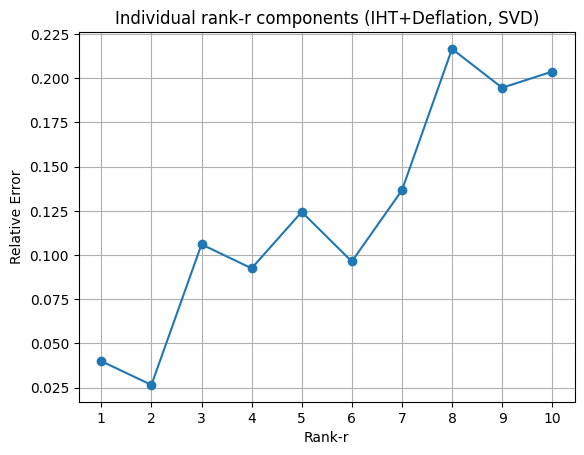

In [26]:
# Plotting the relative error between the IHT and SVD components
plt.plot(range(1, rank+1), rel_error_IHT_SVD, marker='o')
plt.xticks(range(1, rank+1))
plt.xlabel("Rank-r")
plt.ylabel("Relative Error")
plt.title("Individual rank-r components (IHT+Deflation, SVD)")
plt.grid()
plt.show()


Rank 01 - Relative Error: 0.6001042614130497
Rank 02 - Relative Error: 0.36038844380444773
Rank 03 - Relative Error: 0.21576340568963864
Rank 04 - Relative Error: 0.1295357540639591
Rank 05 - Relative Error: 0.07756145173633062
Rank 06 - Relative Error: 0.04648976222084668
Rank 07 - Relative Error: 0.027564688463875327
Rank 08 - Relative Error: 0.01577096148134129
Rank 09 - Relative Error: 0.008150703797887923
Rank 10 - Relative Error: 0.0003691441896957982


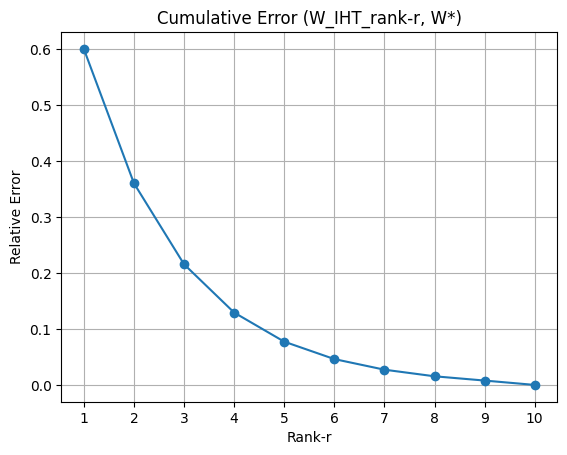

In [27]:
# Cumulative error of rank-r approximation using IHT+Deflation method
W_r_errors = np.zeros(rank)

for i in range(rank):
    W_r = np.sum(W_r1_components[:i+1], axis=0)
    W_r_errors[i] = la.norm(W_r - W_star, ord='fro') / la.norm(W_star, ord='fro')
    print(f"Rank {i+1:02d} - Relative Error: {W_r_errors[i]}")
    
# Plotting the Cumulative error of rank-r approximation
plt.plot(range(1, rank+1), W_r_errors, marker='o')
plt.xticks(range(1, rank+1))
plt.xlabel("Rank-r")
plt.ylabel("Relative Error")
plt.title("Cumulative Error (W_IHT_rank-r, W*)")
plt.grid()

plt.show()

Rank 01 - Relative Error: 0.03998244901166147
Rank 02 - Relative Error: 0.03318721579534323
Rank 03 - Relative Error: 0.01539975082400682
Rank 04 - Relative Error: 0.013953721047932148
Rank 05 - Relative Error: 0.008100997117268548
Rank 06 - Relative Error: 0.0069801422084671055
Rank 07 - Relative Error: 0.0048889463572479525
Rank 08 - Relative Error: 0.0029109325705852164
Rank 09 - Relative Error: 0.0016604094983548618
Rank 10 - Relative Error: 0.0003691441896958212


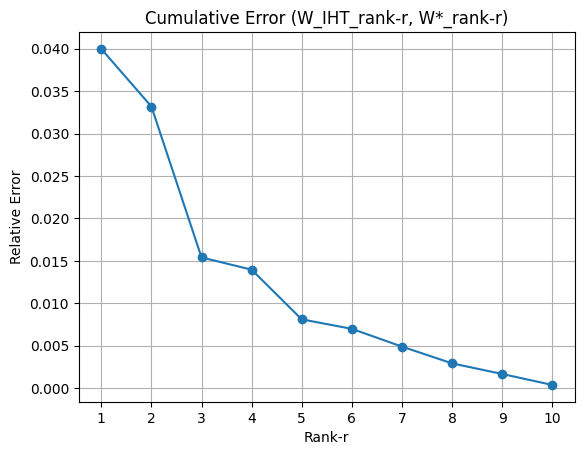

In [28]:
# Cumulative error of rank-r approximation using IHT+Deflation method
W_r_errors = np.zeros(rank)

for i in range(rank):
    W_r = np.sum(W_r1_components[:i+1], axis=0)
    W_star_i = np.sum([S[j] * np.outer(U[:, j], V[j, :]) for j in range(i+1)], axis=0)
    W_r_errors[i] = la.norm(W_r - W_star_i, ord='fro') / la.norm(W_star_i, ord='fro')
    print(f"Rank {i+1:02d} - Relative Error: {W_r_errors[i]}")
    
# Plotting the Cumulative error of rank-r approximation
plt.plot(range(1, rank+1), W_r_errors, marker='o')
plt.xticks(range(1, rank+1))
plt.xlabel("Rank-r")
plt.ylabel("Relative Error")
plt.title("Cumulative Error (W_IHT_rank-r, W*_rank-r)")
plt.grid()

plt.show()

## Step 2.1: Implementing Factorized GD

In [85]:
def FactorizedGD(X, Y, W_star, args: GDArgs):
    # Initialization of A and B
    A_new = np.random.randn(args.d, args.r)
    B_new = np.random.randn(args.m, args.r)

    rel_errors = {"A": [], "B": []}

    i = 1
    while i <= args.iters:
        A_old = A_new
        B_old = B_new

        # Compute the gradient of A and B
        grad_A = X.T @ (X @ (A_old @ B_old.T) - Y) @ B_old
        grad_B = (X.T @ (X @ (A_old @ B_old.T) - Y)).T @ A_old

        # Update A and B
        A_new = A_old - args.eta * grad_A
        B_new = B_old - args.eta * grad_B

        # Compute the error
        error_A = la.norm(A_new - A_star, ord="fro") / la.norm(A_star, ord="fro")
        error_B = la.norm(B_new - B_star, ord="fro") / la.norm(B_star, ord="fro")

        # Relative error between the (A, B) and (A*, B*) components
        rel_errors["A"].append(error_A)
        rel_errors["B"].append(error_B)

        # check if the relative error in A, B and A*, B* is smaller than epsilon
        if error_A <= args.epsilon and error_B <= args.epsilon:
            print("Convergence reached. Stopping the algorithm.")
            break

        i += 1

    return A_new, B_new, rel_errors

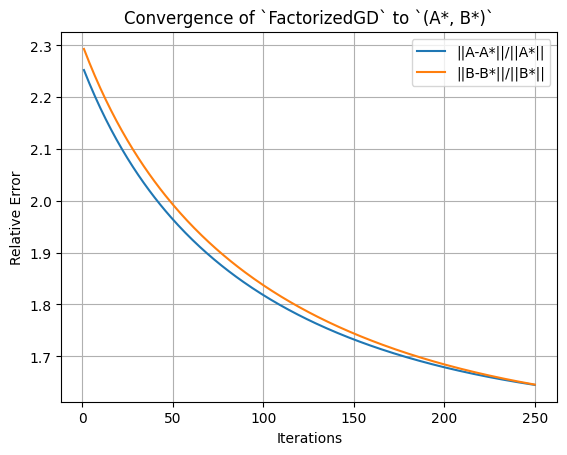

Relative Error of A:  1.644806805676332
Relative Error of B:  1.6454084551295454


In [92]:
args = GDArgs(iters=250, epsilon=1e-8, r=10)
# args.eta = args.eta / (args.r * args.d)
args.eta = 1e-5
A_new, B_new, rel_errors = FactorizedGD(X, Y, W_star, args)

# Plotting the relative error between the (A, B) and (A*, B*) components
plt.plot(range(1, args.iters+1), rel_errors["A"], label="||A-A*||/||A*||")
plt.plot(range(1, args.iters+1), rel_errors["B"], label="||B-B*||/||B*||")
plt.xlabel("Iterations")
plt.ylabel("Relative Error")
plt.title("Convergence of `FactorizedGD` to `(A*, B*)`")
plt.legend()
plt.grid()
plt.show()

print("Relative Error of A: ", rel_errors["A"][-1])
print("Relative Error of B: ", rel_errors["B"][-1])

## Step 2.2: Factorized GD with Orthogonality Constraint

### Step 2.2.1: GD with a weighted Orthogonality regularizer
We will optimize for the new objective function with a weighted orthogonality regularizer. The intention is to have `A` & `B` as orthogonal matrices.

**Loss function**
> $\mathbb{L} = \frac{1}{2} \|Y - AB \cdot X\|_{F}^{2}$

**Orthogonality Constraint** 
> $\mathbb{O}_A = \frac{1}{2} \| A^TA - I \odot A^TA \|_F^2$ \
> $\mathbb{O}_B = \frac{1}{2} \| B^TB - I \odot B^TB \|_F^2$ \
> Where, $A \odot B$ represents the Hadamard Product between `A` and `B`

In [59]:
def MSE_loss_factorized(X, Y, A, B, grad=False):
    if grad:
        grad_A = X.T @ (X @ (A @ B.T) - Y) @ B
        grad_B = (X.T @ (X @ (A @ B.T) - Y)).T @ A
        return grad_A, grad_B
    return 0.5 * la.norm(X @ (A @ B.T) - Y, ord="fro") ** 2


def Orthogonal_loss_factorized(A, B, grad=False):
    gram_A = A.T @ A
    gram_B = B.T @ B
    if grad:
        grad_A = A @ (gram_A - np.eye(gram_A.shape[0]) * gram_A)
        grad_B = B @ (gram_B - np.eye(gram_B.shape[0]) * gram_B)
        return grad_A, grad_B
    orth_A = 0.5 * la.norm(gram_A - np.eye(gram_A.shape[0]) * gram_A, ord="fro")
    orth_B = 0.5 * la.norm(gram_B - np.eye(gram_B.shape[0]) * gram_B, ord="fro")
    return orth_A, orth_B

In [60]:
print(MSE_loss_factorized(X, Y, A_star, B_star), Orthogonal_loss_factorized(A_star, B_star))
print(MSE_loss_factorized(X, Y, A_new, B_new), Orthogonal_loss_factorized(A_new, B_new))

0.12500000000000006 (2.7642374702702168e-14, 2.3113087902913448e-14)
73009.77065390887 (52.44750025124341, 54.48401115764106)


In [127]:
def FactorizedGD_Orth_1(X, Y, init_AB, W_star, args: GDArgs):
    A_new, B_new = init_AB(args)
    
    # Initialization of A and B
    # A_new = np.random.randn(args.d, args.r)
    # B_new = np.random.randn(args.m, args.r)

    # Error and relative error
    errors = {"orth_A": [], "orth_B": [], "MSE": []}
    rel_errors = {"A": [], "B": []}

    i = 1
    while i <= args.iters:
        A_old = A_new
        B_old = B_new

        # Compute the gradient of A and B
        grad_A, grad_B = MSE_loss_factorized(X, Y, A_old, B_old, grad=True)
        grad_A_orth, grad_B_orth = Orthogonal_loss_factorized(A_old, B_old, grad=True)

        # Update A and B
        A_new = A_old - args.eta * grad_A - args.eta_A * grad_A_orth
        B_new = B_old - args.eta * grad_B - args.eta_B * grad_B_orth
        # A_new = A_old - args.eta * (grad_A)
        # B_new = B_old - args.eta * (grad_B)

        # Compute the error
        orth_A, orth_B = Orthogonal_loss_factorized(A_new, B_new)
        mse = MSE_loss_factorized(X, Y, A_new, B_new)

        # Relative error between the (A, B) and (A*, B*) components
        errors["orth_A"].append(orth_A)
        errors["orth_B"].append(orth_B)
        errors["MSE"].append(mse)

        # Compute relative errors
        error_A = la.norm(A_new - A_star, ord="fro") / la.norm(A_star, ord="fro")
        error_B = la.norm(B_new - B_star, ord="fro") / la.norm(B_star, ord="fro")

        # Relative error between the (A, B) and (A*, B*) components
        rel_errors["A"].append(error_A)
        rel_errors["B"].append(error_B)

        # check if the relative error in A, B and A*, B* is smaller than epsilon
        if error_A <= args.epsilon and error_B <= args.epsilon:
            print("Convergence reached. Stopping the algorithm.")
            break

        i += 1

    return A_new, B_new, rel_errors, errors

In [128]:
# Initializations of A and B

def random_AB(args: GDArgs):
    """
    Random initialization of A and B
    """
    return np.random.randn(args.d, args.r), np.random.randn(args.m, args.r)

def orthogonal_AB(args: GDArgs):
    """
    Orthogonal initialization of A and B
    """
    A = np.random.randn(args.d, args.r)
    B = np.random.randn(args.m, args.r)
    
    # Orthogonalizing A and B
    A, _ = la.qr(A)
    B, _ = la.qr(B)
    
    return A, B


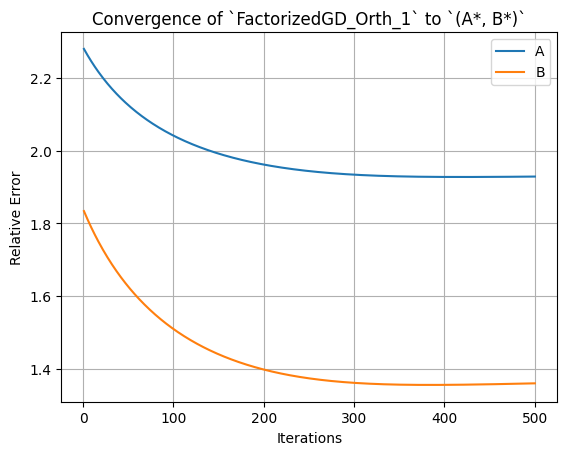

Relative Error of A:  1.9285149718095178
Relative Error of B:  1.3605766632591443


In [131]:
## Testing convergence of FactorizedGD_Orth_1 with random initialization

args = GDArgs(iters=500, epsilon=1e-8, r=10)
args.eta = 1e-5
args.eta_A, args.eta_B = 1e-5, 1e-5
A_new, B_new, rel_errors, errors = FactorizedGD_Orth_1(X, Y, random_AB, W_star, args)

# Plotting the relative error between the (A, B) and (A*, B*) components
plt.plot(range(1, args.iters+1), rel_errors["A"], label="A")
plt.plot(range(1, args.iters+1), rel_errors["B"], label="B")
plt.xlabel("Iterations")
plt.ylabel("Relative Error")
plt.title("Convergence of `FactorizedGD_Orth_1` to `(A*, B*)`")
plt.legend()
plt.grid()
plt.show()

print("Relative Error of A: ", rel_errors["A"][-1])
print("Relative Error of B: ", rel_errors["B"][-1])

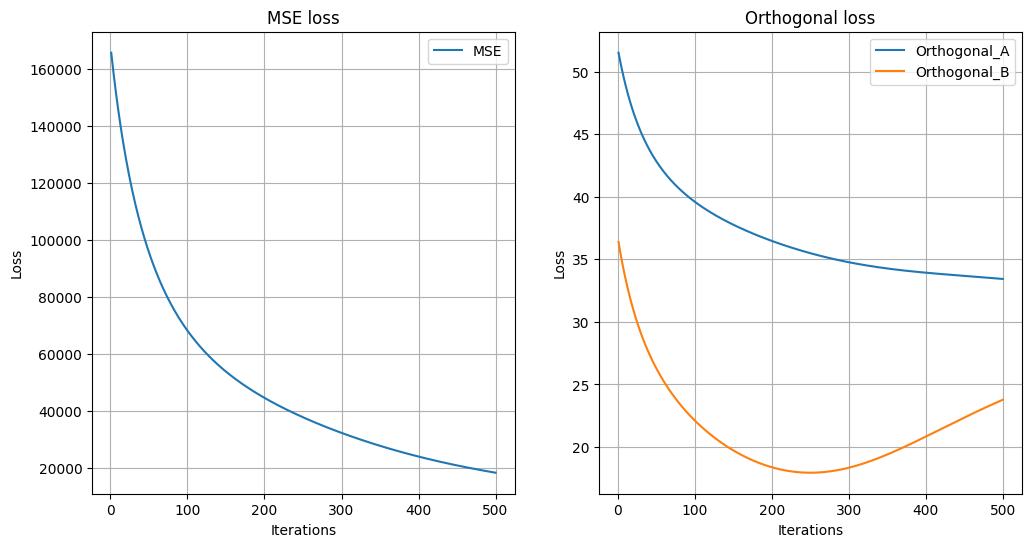

In [132]:
# Plotting the MSE and Orthogonal loss side by side

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(errors["MSE"])+1), errors["MSE"], label="MSE")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("MSE loss")
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(errors["orth_A"])+1), errors["orth_A"], label="Orthogonal_A")
plt.plot(range(1, len(errors["orth_B"])+1), errors["orth_B"], label="Orthogonal_B")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Orthogonal loss")
plt.grid()
plt.legend()

plt.show()